In [84]:
import numpy as np
from numpy.random import choice, random
import matplotlib.pyplot as plt
from typing import Tuple, Optional

In [85]:
class GridWorldCell:
    """Base class for all cells in the grid world."""
    def __init__(self, x: int, y: int, char: str = ' ', color: Tuple[int, int, int] = (0, 0, 0), reward: int = 0):
        self.x: int = x
        self.y: int = y
        self._char: str = char
        self._color: Tuple[int, int, int] = color
        self._reward: int = reward

    @property
    def char(self) -> str:
        return self._char

    @char.setter
    def char(self, value: str):
        self._char = value

    @property
    def color(self) -> Tuple[int, int, int]:
        return self._color

    @color.setter
    def color(self, value: Tuple[int, int, int]):
        self._color = value

    @property
    def reward(self) -> int:
        return self._reward

    @reward.setter
    def reward(self, value: int):
        self._reward = value

    def __str__(self) -> str:
        description_str = (
            f'Type: {self.__class__.__name__} ({self.char} - {self.color})\n'
            f'Position: ({self.x}, {self.y})\n'
            f'Reward: {self.reward}\n'
        )
        return description_str


class TreeAppleCell(GridWorldCell):
    """Represents a tree that can have an apple."""

    def __init__(self, x: int, y: int, with_apple: bool = True):
        super().__init__(x, y)
        self.with_apple: bool = with_apple

    @property
    def char(self) -> str:
        return 'A' if self.with_apple else 'T'

    @property
    def color(self) -> Tuple[int, int, int]:
        return (45, 135, 87) if self.with_apple else (40, 117, 76)

    @property
    def reward(self) -> int:
        return 1 if self.with_apple else 0

    def __str__(self) -> str:
        description_str = super().__str__()
        description_str += f'Apple: {self.with_apple}\n'
        return description_str


class WallCell(GridWorldCell):
    """Represents a wall cell that cannot be traversed."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y, char='W', color=(157, 161, 159))


class GrassCell(GridWorldCell):
    """Represents a grass cell that can be traversed."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y, char=' ', color=(201, 242, 203))


class RespawnCell(GridWorldCell):
    """Represents a respawn point for agents."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y, char='P', color=(201, 242, 203))


class PrincipalRespawnCell(RespawnCell):
    """Represents the principal respawn point."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y)
        self.char = 'Q'
        self.color = (223, 235, 54)


In [86]:
agent_colors = ['#b510a7','#f28424','#05fcaa',
                '#f51bd4','#eeff03','#033dff']

class Agent:
    def __init__(self, x: int, y: int, world_knowledge:np.array,
                 actions: Tuple[str, str, str, str] = ('up', 'down', 'left', 'right'),
                 alhpa: float = 0.1, gamma: float = 0.9, epsilon: float = 0.1,
                 color: Tuple[int, int, int] = (0, 0, 0)):
        
        self.current_state = (x, y)
        self.actions = actions
        self.alpha = alhpa
        self.gamma = gamma
        self.epsilon = epsilon
        self.color: Tuple[int, int, int] = color
        self.world_knowledge = world_knowledge
        self.n_cols, self.n_rows = world_knowledge.shape
        self.knowledge = {(i,j): {} for i in range(self.n_rows) for j in range(self.n_cols)}
        
    def get_next_state(self, base_state, next_action: str) -> tuple:
        if next_action == 'up':
            new_state = (max(base_state[0] - 1, 0), base_state[1])
        elif next_action == 'down':
            new_state = (min(base_state[0] + 1, self.n_rows - 1), base_state[1])
        elif next_action == 'left':
            new_state = (base_state[0], max(base_state[1] - 1, 0))
        elif next_action == 'right':
            new_state = (base_state[0], min(base_state[1] + 1, self.n_cols - 1))               
        return new_state
    
    
    def move(self):
        next_action = choice(self.actions)
        new_x, new_y = self.get_next_state(self.current_state, next_action)
        
        if (new_x, new_y) == self.current_state:
            return
        
        if self.world_knowledge[new_x, new_y].char == 'A':
            self.world_knowledge[new_x, new_y].with_apple = False
            
        self.x, self.y = new_x, new_y
        
        
        def get_best_action(self, state):
            possible_actions = [a for a in self.actions if self.get_next_state(state, a) != state]
            random.shuffle(possible_actions)
            
            if not possible_actions:
                return None, 0
            
            # Obtener el valor mínimo conocido para las acciones posibles
            min_value = min([self.knowledge[state].get(a, 0) for a in possible_actions], default=0)
            
            # Ordenar las acciones por el valor Q estimado
            actions = sorted([(a, self.knowledge[state].get(a, min_value + 0.1 * min_value)) 
                            for a in possible_actions], 
                            key=lambda x: x[1], reverse=True)
            
            return actions[0]

    def calculate_next_action_reward(self, next_state, action):
        if next_state == self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Valor Q actual para la acción
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Valor Q máximo en el siguiente estado
        _, q_max_a_st1 = self.get_best_action(next_state)
        
        # Actualización de Q-learning
        q = q_a_st + self.alpha * (self.world_knowledge[next_state] + self.gamma * q_max_a_st1 - q_a_st)
        
        return q
    
    def update_q_knowledge(self):
        for action in self.actions:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)
    
    def choose_greedy_action(self, epsilon):
        if random.random() < epsilon:
            return random.choice(self.actions)
        else:
            best_action, max_reward = self.get_best_action(self.current_state)
            self.knowledge[self.current_state]['short_memory'].append(max_reward)
            self.current_reward = max_reward
            
            return best_action

In [87]:
class HarvestWorld():
    def __init__(self, ascii_map:str, regrowth_probs:list[float], num_agents:int=0):
        # max number of agents equal to 5
        if num_agents > 6:
            raise ValueError('The maximum number of agents is 2.') 
        
        self.timestep = 0
        self.ASCII_MAP = ascii_map
        self.regrowth_probs = regrowth_probs
        self.ascii_matrix = np.array([list(row) for row in ascii_map.strip().split('\n')])
        self.object_map = self.create_object_map()
        self.appletree_positions = [(cell.x, cell.y) for cell in self.object_map.flatten()
                                    if isinstance(cell, TreeAppleCell)]
        self.respawn_positions = [(cell.x, cell.y) for cell in self.object_map.flatten()
                                    if isinstance(cell, RespawnCell)]
        # use respawn_positions to place agents
        self.agents = [Agent(x=xy[0], y=xy[1], 
                             world_knowledge=self.object_map,
                             color=agent_colors[n]) for n, xy in enumerate(self.respawn_positions[:num_agents])]        
 
        
        
    def create_object_map(self):
        object_map = np.empty(self.ascii_matrix.shape, dtype=object)
        for i in range(self.ascii_matrix.shape[0]):
            for j in range(self.ascii_matrix.shape[1]):
                cell_char = self.ascii_matrix[i, j]
                if cell_char == 'W':
                    object_map[i, j] = WallCell(i, j)
                elif cell_char in {'A', 'T'}:
                    with_apple = cell_char == 'A'
                    object_map[i, j] = TreeAppleCell(i, j, with_apple)
                elif cell_char == 'P':
                    object_map[i, j] = RespawnCell(i, j)
                elif cell_char == 'Q':
                    object_map[i, j] = PrincipalRespawnCell(i, j)
                else:
                    object_map[i, j] = GrassCell(i, j)
                    
        return object_map
    
    
    def get_apple_positions(self):
        return [(x,y) for x,y in self.appletree_positions if self.object_map[x,y].with_apple]

    
    def plot_map(self):
        plt.clf()
        
        plt.title(f'Timestep: {self.timestep} - Total Apples: {len(self.get_apple_positions())}')
        plt.imshow([[c.color for c in row] for row in self.object_map])
        
        apple_positions = self.get_apple_positions()
        
        if apple_positions:
            x_coords, y_coords = zip(*apple_positions)
            plt.scatter(y_coords, x_coords, color='red')
            
        if self.agents:
            x_coords, y_coords = zip(*[(agent.x, agent.y) for agent in self.agents])
            plt.scatter(y_coords, x_coords, color=agent_colors[:len(self.agents)],marker='^')

        
        plt.show()
        
        
    def advance_timestep(self):
        self.timestep += 1
        
        apple_positions = self.get_apple_positions()
        for apple_tree in self.appletree_positions:
            if apple_tree not in apple_positions:
                regrowth = choice(self.regrowth_probs)
                if random() < regrowth:
                    self.object_map[apple_tree].with_apple = True
                    
        for agent in self.agents:
            agent.move()
        
        return self.timestep

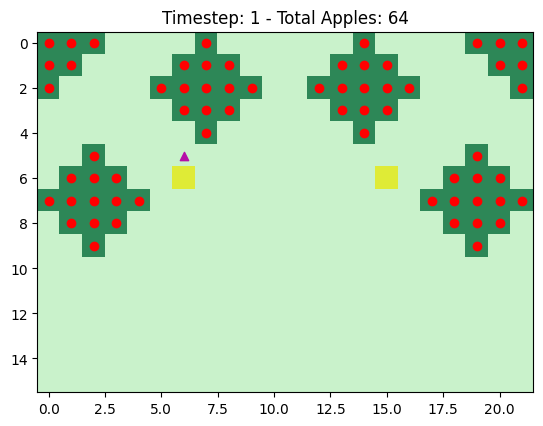

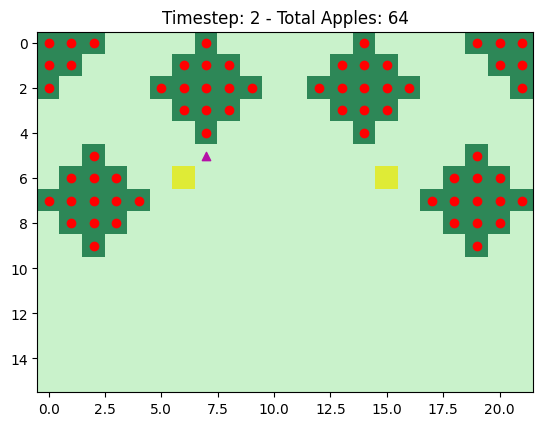

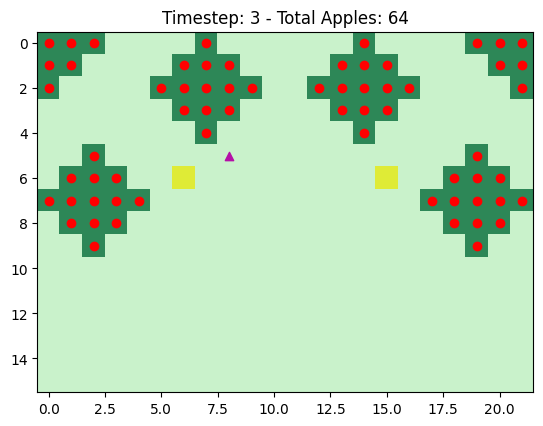

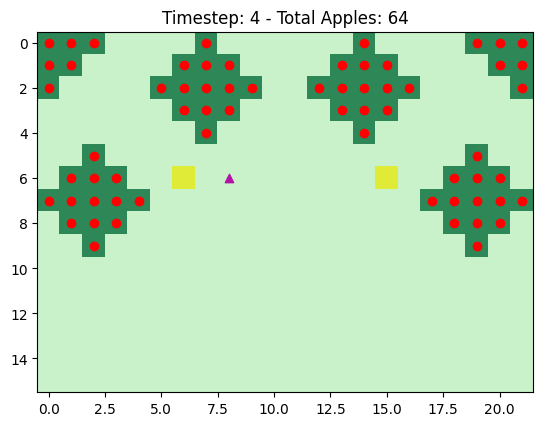

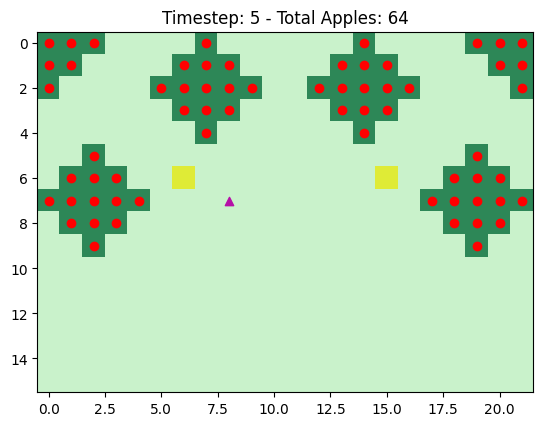

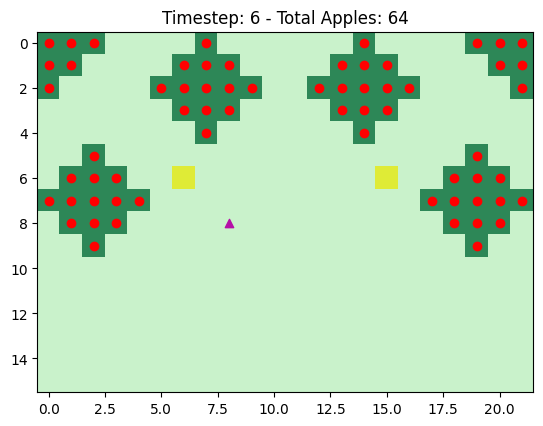

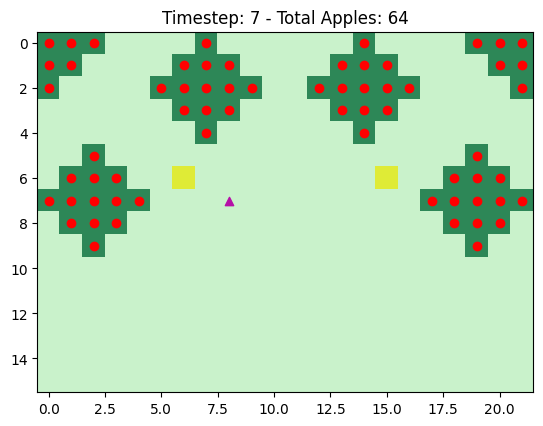

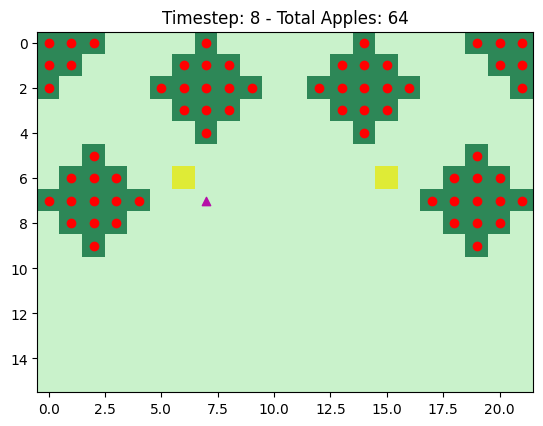

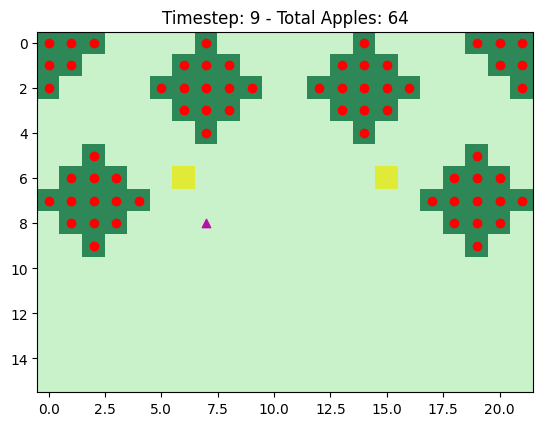

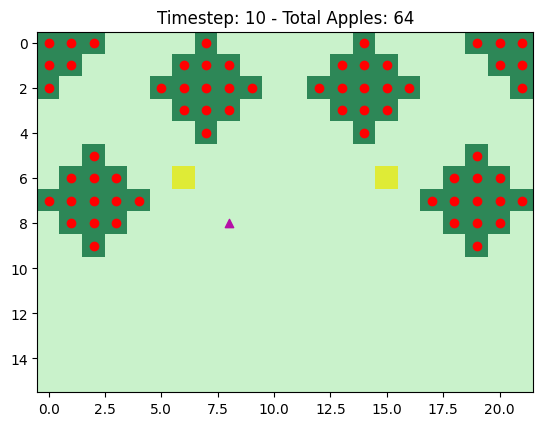

In [91]:
ASCII_MAP = """
AAA    A      A    AAA
AA    AAA    AAA    AA
A    AAAAA  AAAAA    A
      AAA    AAA      
       A      A       
  A                A  
 AAA  Q        Q  AAA 
AAAAA            AAAAA
 AAA              AAA 
  A                A  
                      
                      
                      
  PPPPPPPPPPPPPPPPPP  
 PPPPPPPPPPPPPPPPPPPP 
PPPPPPPPPPPPPPPPPPPPPP
"""

harvest_world = HarvestWorld(ASCII_MAP, 
                             regrowth_probs=[0.0, 0.005],
                             num_agents=1)

for _ in range(10):
    harvest_world.advance_timestep()
    harvest_world.plot_map()
    plt.pause(0.001)